# Strum-Liouville System

## Introduction

Let $K$ be a bounded function on $y \in [-\frac\pi2, \frac\pi2]$. We want to find the eigenvalue and eigenfunction to the following Strum-Liouville System with Dirichlet Boundary condition:
$
\newcommand{\pth}[1]{\left(#1\right)}
\newcommand{\d}{\mathrm{d}}
\newcommand{\dfr}[2]{\frac{\d #1}{\d #2}}
$
\begin{align}
\tag{1}
-\phi'' (y) + K (y) \phi (y) = \lambda \phi (y), \qquad \phi \pth{-\frac\pi2} = \phi \pth{\frac\pi2} = 0.
\end{align}
We want to use power method. First, we introduce the Boundary Value Problem solver operator. Given a function $f$, we solve the following Boundary Value Problem
\begin{align}
\tag{2}
-\phi'' (y) + K (y) \phi (y) = f (y), \qquad \phi \pth{-\frac\pi2} = \phi \pth{\frac\pi2} = 0.
\end{align}
Let $$T _K = \pth{-\dfr{^2}{y ^2} + K} ^{-1}: f \mapsto \phi$$ be the operator that maps the source function to the solution of (2). With an initial guess on eigenvalue $\mu _0$ and eigenfunction $f _0$, we run the following iteration.
\begin{align}
\tag{3}
\phi _k = T _{K - \mu _0} f _k, \qquad \mu _{k + 1} = \frac{\|f _k\| _{L^2}}{\|\phi _k\| _{L^2}}, \qquad f _{k + 1} = \frac{\phi _k}{\|\phi _k\| _{L^2}}.
\end{align}
As it goes, $\mu _k ^{-1}$ should converge to the largest eigenvalue of $T _{K - \mu _0}$, $\mu _k$ should converge to the smallest eigenvalue of $-\dfr{^2}{y^2} + (K - \mu _0)$, thus $\mu _k + \mu _0$ will converge to the eigenvalue closest to $\mu _0$, and we can return $\mu _k + \mu _0$ to be the eigenvalue, and $\phi _k$ to be the eigenfunction.

## BVP Solver

In [1]:
import numpy as np
from numpy import cos, exp, pi, sqrt, floor, ceil, log, arctan
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp

Now we realize the operator $T _K$. We write a function `BVP_solver`. It should take two arguments $K$ and $f$, both functions, and return a function $\phi$.

Define the initial mesh with 5 nodes. Use 0 as initial guess.

In [2]:
initial_mesh = np.linspace(-pi / 2, pi / 2, 5)
initial_func = np.zeros((2, initial_mesh.size))

Now we program the BVP solver. Convert the equation into first order system with Dirichlet boundary conditions.
\begin{align}
    \tag{4}
    \dfr{}{y} \begin{pmatrix}
        \phi \\
        \phi'
    \end{pmatrix} = \begin{pmatrix}
        0 & 1 \\
        K & 0
    \end{pmatrix} \begin{pmatrix}
        \phi \\
        \phi'
    \end{pmatrix} + \begin{pmatrix}
        0 \\
        -f
    \end{pmatrix}.
\end{align}
Then use `solve_bvp` function from `scipy` library.

In [3]:
EPSILON = 1e-10

def BVP_solver(K, f):
    fun = lambda y, phi: np.vstack((phi[1], K(y) * phi[0] - f(y)))
    bc = lambda ya, yb: np.array([ya[0], yb[0]])
    sol = solve_bvp(fun, bc, initial_mesh, initial_func, tol=EPSILON).sol
    sol.c = sol.c[:,:,0] # sol = (phi, phi') is an interpolation polynomial, and sol.c is a tensor of coefficients. This takes the first argument phi.
    
    return sol

Let's try a test run.

CPU times: user 26.5 ms, sys: 5.32 ms, total: 31.8 ms
Wall time: 30.5 ms


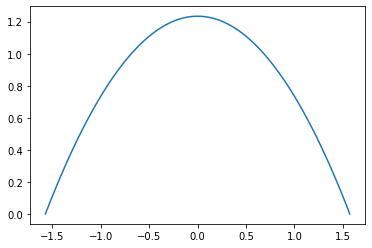

In [4]:
%%time

def graph(fun):
    y_plot = np.linspace(-pi / 2, pi / 2, 100)
    phi_plot = [fun(y) for y in y_plot]
    plt.plot(y_plot, phi_plot)
    
test_f = lambda _: 1
test_K = lambda _: 0
test_sol = BVP_solver(test_K, test_f)
graph(test_sol)

## Iteration

Now we build the iteration. We need to realize several functions. First, the $L^2$ norm of a function can be approximated by

In [5]:
def L2_norm(phi):
    y_sample = np.linspace(-pi / 2, pi / 2, 100)
    phi_sample = [phi(y) for y in y_sample]
    if phi_sample[31] > 0:
        sign = 1
    else:
        sign = -1
    return norm(phi_sample) * sqrt(pi / 100) * sign

Let's try a test run.

In [6]:
print(L2_norm(lambda y: pow(y, 2)))
print(np.math.sqrt(np.math.pow(pi, 5) / 80))

1.9952021753076212
1.9558236269704938


We now realize algorithm (3). Function `eigen` takes three arguments, which are multiplier $K$, initial guess $\mu _0$ and $f _0$. It returns a tuple, (eigenvalue, eigenfunction, number of iteration).

In [7]:
MAX_ITERATION = 100

def eigen(K, mu_0 = -3, f = exp):
    K_mu_0 = lambda y: K(y) - mu_0
    old_mu = np.inf
    i = 0
    for i in range(MAX_ITERATION):
        phi = BVP_solver(K_mu_0, f)
        mu_k = L2_norm(f) / L2_norm(phi)
        f = phi
        f.c = f.c / L2_norm(phi) # phi is an interpolation polynomial, so we scale the coefficient matrix c.
        if abs(mu_k - old_mu) < EPSILON:
            break
        old_mu = mu_k
    return (mu_k + mu_0, f, i)

Let's do a test run to confirm the accuracy is satisfactory.

In [8]:
%%time

test_K = lambda _: 0
test_mu_0 = 5
test_f_0 = exp
print(eigen(test_K, test_mu_0, test_f_0))

(4.000000000018323, <scipy.interpolate.interpolate.PPoly object at 0x18192fee90>, 10)
CPU times: user 220 ms, sys: 4.08 ms, total: 224 ms
Wall time: 223 ms


# Reighley-Kuo Equation

## Setup of the Equation

We want to find the smallest eigenvalue to the Strum-Liouville System with Dirichlet Boundary condition
$$
-\phi''-\frac{\beta - U''}{U - c}\phi = \lambda \phi, \qquad \phi \pth{\pm\frac\pi2} = 0.
$$


In our case, 
$$U(y) = \cos ^2 (y), \qquad U''(y) = 2 - 4 \cos ^2 (y).$$

In [9]:
U = lambda y: cos(y) * cos(y)
Upp = lambda y: 2 - 4 * U(y)

Comparing to the model in our article, the domain is rescaled from $[-1, 1]$ to $[-\pi/2, \pi/2]$, for computational simplicity. Therefore, some results here differ from the article by a factor of $\pi/2$ or $\pi^2/4$.

We first define the coefficient function
$$
K_{\beta,c}(y) = -\frac{\beta - U''(y)}{U(y) - c}.
$$

In [10]:
def K(beta, c):
    return lambda y: -(beta - Upp(y)) / (U(y) - c)

Let's find the eigenvalue of the case $\beta = -1.8$, $c = 1.1$ for exammple.

(-0.5288820708571951, <scipy.interpolate.interpolate.PPoly object at 0x15188e0410>, 14)
CPU times: user 344 ms, sys: 3.56 ms, total: 348 ms
Wall time: 346 ms


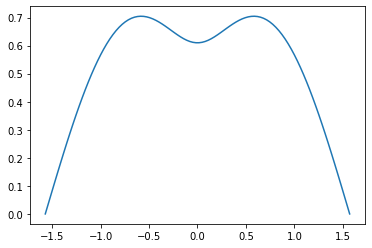

In [11]:
%%time

test_sol = eigen(K(-1.8,1.1), mu_0=0)
print(test_sol)
graph(test_sol[1])

Now we define $\lambda _1 (\beta, c)$ to be the principal eigenvalue of $K _{\beta, c}$. Because the eigenvalues are greater than $-3$, we can use default $\mu _0 = -3$ to find smallest eigenvalue.

In [12]:
def lambda1(beta, c, mu_0 = -3, f = exp):
    res = eigen(K(beta, c), mu_0, f)
    if res[2] < MAX_ITERATION - 1:
        return (res[0], res[1])
    else:
        res = eigen(K(beta, c), mu_0 * 1.01, f)
        if res[2] < MAX_ITERATION - 1:
            return (res[0], res[1])
        else:
            return (np.nan, exp)

A test run.

In [13]:
lambda1(-3, 2, mu_0=-2)

(-0.5385420390101288, <scipy.interpolate.interpolate.PPoly at 0x1067e6470>)

## Eigenvalue Plot

We want to compute the eigenvalue and eigenvector for $\beta \in (\beta _1, \beta _2)$ and $c \in (c _1, c _2)$. The following function will take arguments `beta_sample` and `c_sample`, then return the eigenvalue and eigenfunction matrix, and does a contourplot of eigenvalues. The idea is the following. Because when the system is regular, the eigenvalues are analytic in $\beta$ and $c$, so once we found the eigenvalue and eigenfunction at one grid, we can use them as initial guess for the eigenvalues nearby, which can speed up the computation. In the following, we use a linear combinition of the previous two eigenvalues. 


Linear extrapolation: $y _0 = f (x _0)$, $y _1 = f(x _1)$, so
$$
  y _2 = \frac{y _1 - y _0}{x _1 - x _0} (x _2 - x _1) + y _1 = \frac{x _2 - x _1}{x _0 - x _1} y _0 + \frac{x _2 - x _0}{x _1 - x _0} y _1 := a _0 y _0 + a _1 y _1.
$$

In [14]:
def linearExtrapolate(x0, x1, x2, y0, y1):
    a0 = (x2 - x1) / (x0 - x1)
    a1 = (x2 - x0) / (x1 - x0)
    return a0 * y0 + a1 * y1

In [15]:
# This is a library that enable it to show a progress bar for our long calculation. 
# Each of the calculateEigen procedure takes about one hour in my case.

try:
  import progressbar
except:
  from pip._internal import main as pipmain
  pipmain(['install', 'progressbar2'])
  import progressbar

In [16]:
def calculateEigen(beta_sample, c_sample, mu_0 = -3, f = exp):

    beta_size = len(beta_sample)
    c_size = len(c_sample)
    evMat = np.full((beta_size, c_size), np.nan)
    efMat = np.full((beta_size, c_size), exp)

    for i in progressbar.progressbar(range(beta_size)):
        beta = beta_sample[i]
        for j in range(c_size):
            c = c_sample[j]
            if i == 0:
                if j == 0:
                    (evMat[i, j], efMat[i, j]) = lambda1(beta, c, mu_0, f)
                elif j == 1:
                    (evMat[i, j], efMat[i, j]) = lambda1(beta, c, evMat[i, j - 1], efMat[i, j - 1])
                else:
                    evTest = linearExtrapolate(c_sample[j - 2], c_sample[j - 1], c_sample[j], evMat[i, j - 2], evMat[i, j - 1])
                    (evMat[i, j], efMat[i, j]) = lambda1(beta, c, evTest, efMat[i, j - 1])
            elif i == 1:
                (evMat[i, j], efMat[i, j]) = lambda1(beta, c, evMat[i - 1, j], efMat[i - 1, j])
            else:
                evTest = linearExtrapolate(beta_sample[i - 2], beta_sample[i - 1], beta_sample[i], evMat[i - 2, j], evMat[i - 1, j])
                (evMat[i, j], efMat[i, j]) = lambda1(beta, c, evTest, efMat[i - 1, j])
                if np.isnan(evMat[i, j]):
                    (evMat[i, j], efMat[i, j]) = lambda1(beta, c, evTest * 1.01, efMat[i, j - 1])
    
    betaMat, cMat = np.meshgrid(beta_sample, c_sample)
    return (betaMat, cMat, evMat, efMat)

def eigenPlot(result, minEigen = np.nan, maxEigen = np.nan, level_increment = 1, figure_size=(12, 6), label=False):
    plt.figure(figsize=figure_size)
    if np.isnan(minEigen):
        minEigen = floor(np.array(result[2]).min() / level_increment) * level_increment
    if np.isnan(maxEigen):
        maxEigen = ceil(np.array(result[2]).max() / level_increment) * level_increment
    number_of_levels = int(round((maxEigen - minEigen) / level_increment + 1))
    CS = plt.contour(result[0], result[1], result[2].T, levels = np.linspace(minEigen, maxEigen, number_of_levels), manual=label)
    plt.clabel(CS, inline=1, fontsize=10, colors='k')

Now draw the eigenvalue in the region $-3 < \beta < 3$, $1 < c < 2$. Since as $c \to 1 ^+$, the system becomes singular, we need to add more sample grids near $c = 1$. Here we use exponential.

100% (601 of 601) |######################| Elapsed Time: 1:25:01 Time:  1:25:01
/Users/jincheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: The following kwargs were not used by contour: 'manual'


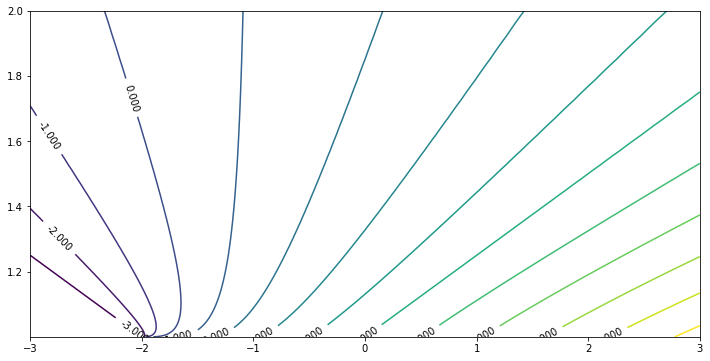

In [17]:
beta_sample = np.linspace(-3, 3, 601)
c_sample = [1 + exp(-0.08 * x) for x in range(100)]
res1 = calculateEigen(beta_sample, c_sample)
eigenPlot(res1, minEigen = -3, maxEigen = 10)

For the region $-3 < \beta < 3$, $-1 < c < 0$, again because as $c \to 0 ^-$, the system becomes singular, we use exponential samples.

100% (601 of 601) |######################| Elapsed Time: 1:25:11 Time:  1:25:11
/Users/jincheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: The following kwargs were not used by contour: 'manual'


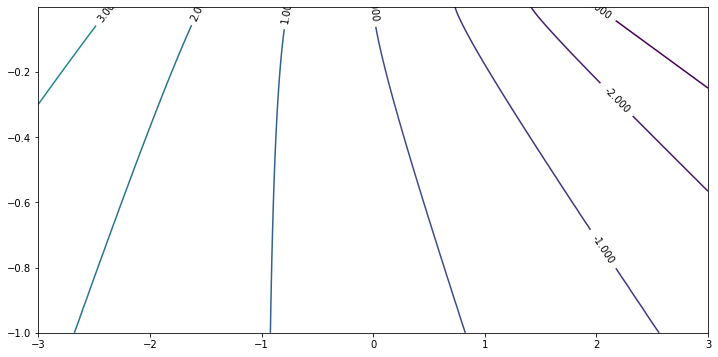

In [18]:
beta_sample = np.linspace(-3, 3, 601)
c_sample = [-exp(-0.08 * x) for x in range(100)]
res0 = calculateEigen(beta_sample, c_sample)
eigenPlot(res0, minEigen = -3, maxEigen = 10)

We can patch them together by doing a transform $\tilde c = \frac1{c - 1/2}$. In this way we may have a better view of the shape of the eigenvalues.

In [19]:
beta_sample = np.linspace(-3, 3, 601)
c_tilde_sample_negative = [-2 + 2 * exp(-0.08 * x) for x in range(1, 100)]
c_tilde_sample_positive = [2 - 2 * exp(-0.08 * x) for x in range(1, 100)]
c_sample_negative = [1/2 + 1 / x for x in c_tilde_sample_negative]
c_sample_positive = [1/2 + 1 / x for x in c_tilde_sample_positive]
restilde_negative = calculateEigen(beta_sample, c_sample_negative, mu_0 = -1)
restilde_positive = calculateEigen(beta_sample, c_sample_positive, mu_0 = -1)
c_tilde_sample_negative.reverse()
c_tilde_sample = c_tilde_sample_negative + c_tilde_sample_positive
restilde_neg = restilde_negative[2].T.tolist()
restilde_neg.reverse()
restilde_pos = restilde_positive[2].T.tolist()
res_mat = restilde_neg + restilde_pos
bMat, cMat = np.meshgrid(beta_sample, c_tilde_sample)

100% (601 of 601) |######################| Elapsed Time: 1:25:02 Time:  1:25:02
100% (601 of 601) |######################| Elapsed Time: 1:22:29 Time:  1:22:29


<a list of 20 text.Text objects>

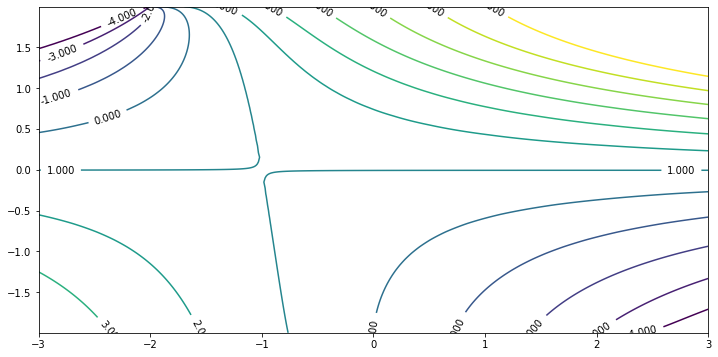

In [20]:
plt.figure(figsize=(12, 6))
CS = plt.contour(bMat, cMat, res_mat, levels = range(-4, 8))
plt.clabel(CS, inline=1, fontsize=10, colors='k')

Apparently there is a saddle point at $(-1, 0)$ that python contourplot cannot draw numerically. This corresponds to the system at $\beta = -1$, $c = \infty$. Since in general

$$
\frac{\partial \lambda _1}{\partial \tilde c} 
= \frac{\partial \lambda _1}{\partial c} \frac{\d c}{\d \tilde c}
= - \int _{-\frac\pi2} ^{\frac\pi2} \frac{\beta - U''}{(U - c) ^2} |\phi| ^2 \d y 
\cdot \left(-\frac1{(c - 1/2)^2}\right) ^{-1}
$$

Here $\phi$ is the corresponding normalized eigenfunction. See equation (3.18) of the article for derivation. When $c \to \infty$, $\tilde c \to 0$, $\phi \to C \cos (y)$, $\lambda _1 \to 1$. Therefore the above partial derivative vanishes at $\beta$ that

$$
\int _{-\frac\pi2} ^{\frac\pi2} (\beta - U'') \cos ^2 (y) \d y = 0.
$$

With $U'' = 2 - 4 \cos (y) ^2$, one easily concludes the saddle point is $\beta = -1$.

To take a closer look at $c = 0$, we test $\beta \in (0.392, 0.408)$, $\beta \in (0.992, 1.008)$, and $\beta \in (1.592, 1.608)$.

100% (400 of 400) |######################| Elapsed Time: 0:47:54 Time:  0:47:54
/Users/jincheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: The following kwargs were not used by contour: 'manual'


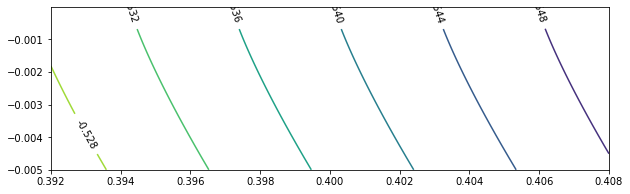

In [21]:
beta_sample = np.linspace(0.392, 0.408, 400)
c_sample = [-0.005 * exp(-0.08 * x) for x in range(100)]
res04 = calculateEigen(beta_sample, c_sample, mu_0 = -0.5)
eigenPlot(res04, level_increment = 0.004, figure_size = (10, 3))

100% (400 of 400) |######################| Elapsed Time: 0:43:03 Time:  0:43:03
/Users/jincheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: The following kwargs were not used by contour: 'manual'


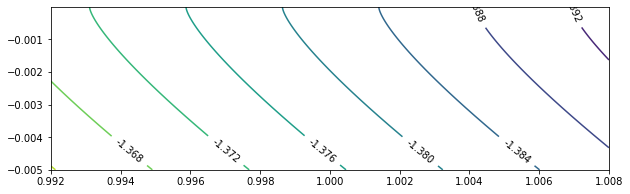

In [22]:
beta_sample = np.linspace(0.992, 1.008, 400)
c_sample = [-0.005 * exp(-0.08 * x) for x in range(100)]
res10 = calculateEigen(beta_sample, c_sample, mu_0 = -1.2)
eigenPlot(res10, level_increment = 0.004, figure_size = (10, 3))

100% (400 of 400) |######################| Elapsed Time: 0:42:50 Time:  0:42:50
/Users/jincheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: The following kwargs were not used by contour: 'manual'


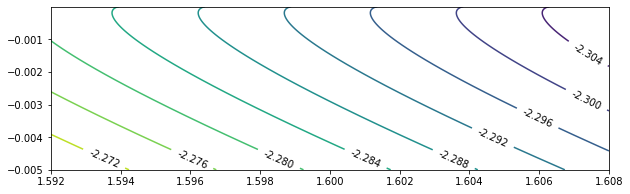

In [23]:
beta_sample = np.linspace(1.592, 1.608, 400)
c_sample = [-0.005 * exp(-0.08 * x) for x in range(100)]
res16 = calculateEigen(beta_sample, c_sample, mu_0 = -2.0)
eigenPlot(res16, level_increment = 0.004, figure_size = (10, 3))

# Instability Boundary

## Rough Graph

For each $\beta \in (-2, 2)$, we need to find $c$ that minimize $\lambda _1 (\beta, c)$. The negative part of the minimum will be denoted by $\Lambda _\beta$. 

In [24]:
beta_sample = np.linspace(-3, 3, 601)
Lambda0 = [min(res0[2][i, :]) for i in range(len(beta_sample))]
Lambda1 = [min(res1[2][i, :]) for i in range(len(beta_sample))]
Lambda_Min = [min(Lambda0[i], Lambda1[i]) for i in range(len(beta_sample))]
Lambda_beta = [max(-Lambda_Min[i], 0) for i in range(len(beta_sample))]

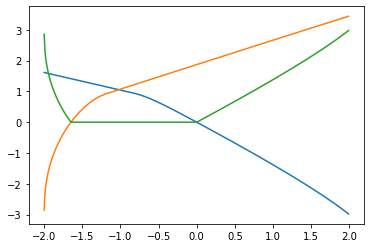

In [25]:
plt.plot(beta_sample[100:500], Lambda0[100:500])
plt.plot(beta_sample[100:500], Lambda1[100:500])
plt.plot(beta_sample[100:500], Lambda_beta[100:500])

Plot for $\alpha = \sqrt{\Lambda _\beta}$.

In [26]:
alpha = [sqrt(Lambda_beta[i]) for i in range(len(beta_sample))]

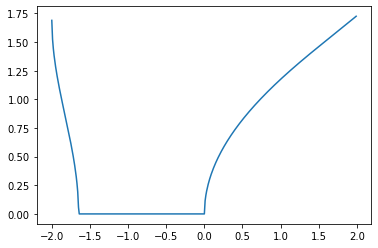

In [27]:
plt.plot(beta_sample[100:500], alpha[100:500])

## Detailed Calculation

For each $\beta$, we will calculate $\Lambda _\beta$ with more accuracy now. We will use a simple optimization method. We first consider $\beta \in \pth{-2, 0}$.

In [28]:
def minimize(f, left, right, ev_left = np.nan, ev_right = np.nan):
    
    gamma = (sqrt(5) - 1) / 2
    if np.isnan(ev_left):
        ev_left = f(left)
    if np.isnan(ev_right):
        ev_right = f(right)
    center_left = right - (right - left) * gamma
    ev_center_left = f(center_left)
    center_right = left + (right - left) * gamma
    ev_center_right = f(center_right)

    while abs(right - left) > EPSILON:
        if ev_center_left < ev_center_right:
            (right, ev_right) = (center_right, ev_center_right)
            (center_right, ev_center_right) = (center_left, ev_center_left)
            center_left = right - (right - left) * gamma
            ev_center_left = f(center_left)
        else:
            (left, ev_left) = (center_left, ev_center_left)
            (center_left, ev_center_left) = (center_right, ev_center_right)
            center_right = left + (right - left) * gamma
            ev_center_right = f(center_right)
    
    final_point = [left, center_left, center_right, right]
    final_value = [ev_left, ev_center_left, ev_center_right, ev_right]
    j = np.argmin(final_value)
    return (final_point[j], final_value[j])

Now use minimize function to refine `Lambda_Min` in $\beta \in (-2, 0)$ and $(0, 2)$ respectively.

In [29]:
c_star = np.zeros_like(beta_sample)
c_sample = [1 + exp(-0.08 * x) for x in range(100)]

for i in progressbar.progressbar(range(100, 140)):

    # find min element
    beta = beta_sample[i]
    j = np.argmin(res1[2][i, :])
    mu_0 = res1[2][i, j]
    phi = res1[3][i, j]

    if j == 0:
        j += 1
    if j == len(c_sample) - 1:
        j -= 1
    
    # use minimize function
    func = lambda c: lambda1(beta, c, mu_0, phi)[0]
    (c_star[i], Lambda_Min[i]) = minimize(func, c_sample[j - 1], c_sample[j + 1])

100% (40 of 40) |########################| Elapsed Time: 0:03:00 Time:  0:03:00


In [30]:
c_sample = [-exp(-0.08 * x) for x in range(100)]
c_sample += [0]

for i in progressbar.progressbar(range(300, 500)):

    # find min element
    beta = beta_sample[i]
    j = np.argmin(res0[2][i, :])
    mu_0 = res0[2][i, j]
    phi = res0[3][i, j]

    if j == 0:
        j += 1
    
    # use minimize function
    func = lambda c: lambda1(beta, c, mu_0, phi)[0]
    (c_star[i], Lambda_Min[i]) = minimize(func, c_sample[j - 1], c_sample[j + 1])

100% (200 of 200) |######################| Elapsed Time: 0:19:07 Time:  0:19:07


Take a look at the plot of $c^*$.

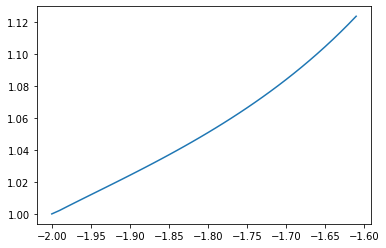

In [31]:
plt.plot(beta_sample[100:140], c_star[100:140])

For $\beta > 0$, $c ^*$ is small but not always zero.

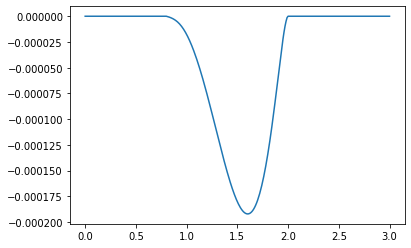

In [32]:
plt.plot(beta_sample[300:], c_star[300:])

Now compare the value of our results and the hypothesis of Kuo.

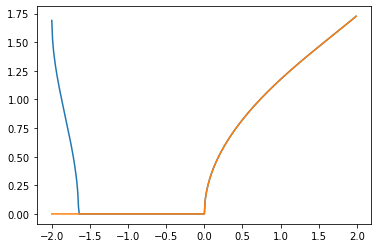

In [33]:
Lambda_beta = [max(-Lambda_Min[i], 0) for i in range(len(beta_sample))]
alpha = [sqrt(Lambda_beta[i]) for i in range(len(beta_sample))]
plt.plot(beta_sample[100:500], alpha[100:500])

hypothesis = np.zeros_like(beta_sample)
for i in range(300, 500):
    hypothesis[i] = 2 * sqrt(1 - pow(sqrt(-beta_sample[i] / 4 + 9 / 16) + 1 / 4, 2))

plt.plot(beta_sample[100:500], hypothesis[100:500])

The difference for $0 < \beta < 2$ is the following.

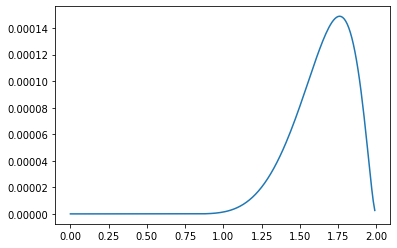

In [34]:
plt.plot(beta_sample[300:500], alpha[300:500] - hypothesis[300:500])

## Calculate $\beta _-$

The question to find $\beta$ can be thought as the following general problem. For a continuous function $f = f(x, y)$, which is continuous in $(x, y)$, monotonously increasing in $x$, single-humped in $y$ (which means for a fixed $x$, $f (x, \cdot)$ is monotone on both sides of the criticle point), we want to find

$$
x _- = \max\left\{x \in [x _1, x _2]: \min _{y \in [y _1, y _2]} f(x, y) \le 0\right\}. 
$$

In [35]:
EPSILON = 1e-7

def maxmin(f, x1, x2, y1, y2):
    
    # Initial x_step_size and y_step_size is a quarter the length
    x_step_size = (x2 - x1) / 4
    y_step_size = (y2 - y1) / 4
    
    bar_max_value = max(log(x_step_size / EPSILON * EPSILON), log(y_step_size / EPSILON))
    bar = progressbar.ProgressBar(max_value = bar_max_value)
    
    while y_step_size > EPSILON or x_step_size > EPSILON * EPSILON:
        
        # First, we take 5 sample on the left edge. Find the minimal one.
        y_list = np.linspace(y1, y2, 5)
        f_list = [f(x1, y_list[i]) for i in range(1, 4)]
        i = np.argmin(f_list)
        yc = y_list[i + 1]
        
        # Second, we go from (x1, yc) to right, until we cross the contour.
        # We quarter the x_step_size every iteration
        if x_step_size > EPSILON * EPSILON:
            x_step_size /= 4
        while (f(x1, yc) < 0):
            x1 += x_step_size
        
        x1 -= x_step_size
        
        # Finally, we shrink the y-window. Go from (x1, yc) up or down until we cross the contour.
        y_step_size = (y2 - y1) / 8
        y1 = yc
        y2 = yc
        while (f(x1, y1) < 0):
            y1 -= y_step_size
        while (f(x1, y2) < 0):
            y2 += y_step_size
        bar.update(bar_max_value - max(log(x_step_size / EPSILON * EPSILON), log(y_step_size / EPSILON), 0))
    
    return x1

Let's run a test. For $f(x, y) = \sin x - 0.5 + y ^2 + e^{x+y}$, the maximum for a fixed $x$ is obtained when

$$
0 = \frac{\partial f}{\partial y} = 2y + e^{x + y}
$$

Therefore this point should be

In [36]:
from scipy.optimize import fsolve

func = lambda x: [np.sin(x[0]) - 0.5 + x[1] * x[1] + exp(x[0] + x[1]), 2 * x[1] + exp (x[0] + x[1])]
fsolve(func, [0, 0])

array([-0.19864597, -0.30282083])

Our maxmin function gives

In [37]:
func = lambda x, y: np.sin(x) - 0.5 + y * y + exp(x + y)
maxmin(func, -1, 1, -1, 1)

N/A% (0 of 15.424948470398375) |         | Elapsed Time: 0:00:00 ETA:  --:--:--

-0.19864596889513564

Let's apply this function on our lambda1 function.

In [38]:
func = lambda b, c: lambda1(b, c, mu_0 = 0)[0]
beta_minus = maxmin(func, -1.7, -1.5, 1.01, 2)

100% (14.721750953984929 of 14.721750953984929) || Elapsed Time: 0:04:54 ETA:  00:00:00

In [39]:
beta_minus

-1.6489545393735134